In [1]:
import os
import joblib
import matplotlib.pyplot as plt
import glob

In [2]:
JOINT_NAMES = [
    'Nose', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'MidHip', 'RHip', 'RKnee',
    'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'REye', 'LEye', 'REar', 'LEar', 'LBigToe', 'LSmallToe', 'LHeel', 'RBigToe',
    'RSmallToe', 'RHeel', 'Right Ankle', 'Right Knee', 'Right Hip', 'Left Hip', 'Left Knee', 'Left Ankle',
    'Right Wrist', 'Right Elbow', 'Right Shoulder', 'Left Shoulder', 'Left Elbow', 'Left Wrist', 'Neck (LSP)',
    'Top of Head (LSP)', 'Pelvis (MPII)', 'Thorax (MPII)', 'Spine (H36M)', 'Jaw (H36M)', 'Head (H36M)',
    'Nose', 'Left Eye', 'Right Eye', 'Left Ear', 'Right Ear'
]

#using first 44
JOINT_NAMES = JOINT_NAMES[:45]

#creating dict of joints
joint_dict = {}
for i in range(0, len(JOINT_NAMES)):
    joint_dict[JOINT_NAMES[i]] = i

In [3]:
def load_pickles(folder='pickles', files=None):

    '''
    Loads pickle files from folder. Either specified list in files or all pkl files inside the folder.

    INPUTS
    ------
        folder : str, default 'pickles'
            directory where pickle files are stored
        files : list, default None
            list of files to load

    OUTPUTS
    -------
        model_outputs : dict
            dictionary of loaded pickle results in PHALP schema (which are also dicts)
    '''


    #storage dict
    model_outputs = {}

    #only specified files
    if files:
        for file in files:
            name = os.path.splitext(file)[0]
            model_outputs[name] = joblib.load(f'{folder}/{file}')

    #everything in pickles directory
    else:
        pickle_files = glob.glob(f'{folder}/*.pkl')
        for file in pickle_files:
            name = os.path.splitext(os.path.basename(file))[0]
            model_outputs[name] = joblib.load(file)

    return model_outputs

def extract_joints(model_output):

    '''
    Extracts joints from pickle file for every detected person.
    
    Basically transforms dictionary obtained through PHALP into more useful schema:

    tracklets = {
      
        #dict for each person
        'person_id' : {
            #dict for each joint
            'joint_name' : {
                #dict for each dimension
                'dimension':    List[numpy.float32]     #value for every detected frame
            }
        }
    
    }

    INPUTS
    ------
        model_output : dict
            phalp_outputs dictionary of single video

    OUTPUTS
    -------
        tracklets : dict
            dictionary of all tracklets in the video with their 3d_joints in 3 dimensions
    '''

    #check how many people are in the video:
    n_tracklets = 0
    for frame in model_output.values():
        n_tracklets = max(n_tracklets, len(frame['tracked_ids']))

    #initialize joints dict with empty list for every detection
    tracklets = {n:{joint:{0:[], 1:[], 2:[]} for joint in joint_dict} for n in range(0, n_tracklets)}

    #loop over frames and extract joints
    for frame in model_output.values():
        for person in frame['tracked_ids']:
            person -= 1
            for joint in joint_dict:
                for dim in range(0,3):
                    tracklets[person][joint][dim].append(frame['3d_joints'][person][joint_dict[joint]][dim])
                
    return tracklets

def plot_joints_trajectory(tracklets, person_id, joint_list, dim):

    '''
    Plots joint trajectories for specified video, person, joint list and dimension.

    INPUTS
    ------
        tracklets : dict
            dict of tracklets from video obtained thorugh extract_joints()
        person_id : int
            index of tracked person to plot
        joint_list : list
            list of joints to plot
        dim : int
            dimension to plot from camera point of view (0 - x axis, 1 - y axis, 2 - z axis)

    '''

    trajectories = {}

    for joint in joint_list:
        trajectories[joint] = tracklets[person_id][joint][dim]
        plt.plot(range(len(trajectories[joint])), trajectories[joint])
    
    #for title purposes
    joint_names = ' & '.join(joint_list)
    
    plt.legend(joint_list)
    plt.title(joint_names)
    plt.show()

In [4]:
#load all pickle files
model_outputs = load_pickles()

tracklets_dict = {}

for video_name, video_results in model_outputs.items():
    tracklets_dict[video_name] = extract_joints(video_results)

The structure of detections_dict we have after the above processing is as follows:

```python
    tracklets_dict = {
    
        #dict for each pickle
        'pickle_name' : {       
            #dict for each person
            'person_id' : {
                #dict for each joint
                'joint_name' : {
                    #dict for each dimension
                    'dimension':    List[numpy.float32]     #value for every detected frame
                }
            }
        }
    }
```

In [5]:
# gives the whole trajectory of RAnkle for a second person in demo_Athletic_Male
tracklets_dict['demo_Athletic_Male'][1]['RAnkle'][0]

[-0.14553805,
 -0.15515436,
 -0.18400419,
 -0.21620455,
 -0.23086983,
 -0.24342905,
 -0.25593024,
 -0.30283558,
 -0.34108073,
 -0.37658578,
 -0.4116593,
 -0.45012948,
 -0.4810732,
 -0.5077377,
 -0.5170067,
 -0.4881981,
 -0.42816556,
 -0.318065,
 -0.2373339,
 -0.13268676,
 0.0009479821,
 0.14466745,
 0.24901952,
 0.33448508,
 0.33804435,
 0.29526702,
 0.24049193,
 0.16595058,
 0.09466116,
 0.008637115,
 -0.025552042,
 -0.07209848,
 -0.13565078,
 -0.19507703,
 -0.25147718,
 -0.30293715,
 -0.35813764,
 -0.41298604,
 -0.45741874,
 -0.47601765,
 -0.45900494,
 -0.42634267,
 -0.35458586,
 -0.2699453,
 -0.1831394,
 -0.08746438,
 0.052201472,
 0.18114147,
 0.28222322,
 0.34171396,
 0.33675784,
 0.29771033,
 0.24197242,
 0.16944516,
 0.1051283,
 0.025810823,
 -0.02097515,
 -0.05976583,
 -0.119651265,
 -0.16961308,
 -0.21804643,
 -0.27710652,
 -0.33320433,
 -0.38515562,
 -0.43604267,
 -0.45017502,
 -0.4452287,
 -0.41159728,
 -0.35067087,
 -0.27842718,
 -0.18381797,
 -0.096033454,
 0.0039328635,
 

```python
cluster_df["pickups"] = pickups_predictions
cluster_df["dropoffs"] = dropoffs_predictions   
# add the amount of bikes that are in deficit

cluster_df["shortage"] =  np.ceil(cluster_df.pickups - cluster_df.dropoffs).astype(int)
# go through the whole test period and see the shortage of bikes per hour
# amount of bikes in deficit is increasing during the or decreasing when more dropoffs than pickups
shortages = []
for date in test_dates.day.unique():
    max_shortage = 0
    shortage = 0
    for hour in range(24):
        shortage += cluster_df[(cluster_df["day"] == date) & (cluster_df["hour"] == hour)]["shortage"].values[0]
        if shortage > max_shortage:
            max_shortage = shortage
    # take the highest amount of missing bikes per cluster per day
    shortages.append(max_shortage)
```

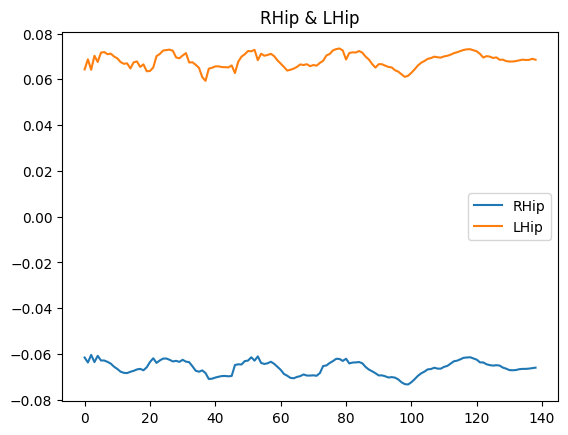

In [6]:
tracklet = tracklets_dict['demo_Athletic_Male']
person_id = 0
joint_list = ['RHip', 'LHip']
dim = 0

plot_joints_trajectory(tracklet, person_id, joint_list, dim)